<a href="https://colab.research.google.com/github/sidharthworks/chat/blob/master/LSTM_Vanilla_Method_52W.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install (if needed) & Imports
# If you're on Colab, TensorFlow is preinstalled. Statsmodels for STL is optional.
!pip -q install statsmodels --upgrade

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import statsmodels.api as sm

# Reproducibility
np.random.seed(42)
tf.keras.utils.set_random_seed(42)

pd.set_option('display.float_format', lambda x: f'{x:,.3f}')


In [ ]:
#@title Parameters (edit here)
# Forecast horizon (weeks ahead)
HORIZON = 52  #@param {type:"integer"}

# Length of the lookback window (weeks)
WINDOW_SIZE = 52  #@param {type:"integer"}

# Validation split fraction (from the training windowed samples)
VAL_SPLIT = 0.2  #@param {type:"number"}

# LSTM hyperparameters
LSTM_UNITS = 64  #@param {type:"integer"}
EPOCHS = 300     #@param {type:"integer"}
BATCH_SIZE = 32  #@param {type:"integer"}

# Which columns represent product groups
SERIES_COLS = ["M01AB","M01AE","N02BA","N02BE","N05B","N05C","R03","R06"]
DATE_COL = "datum"  # in your file, the date column is named 'datum'
FREQ = "W-SUN"      # weekly, Sundays (matches your data)
SEASONAL_PERIOD = 52  # for weekly seasonality in MASE and STL


In [5]:
#@title Load data (upload or Drive/Path)
# Option A: upload file manually in Colab
# from google.colab import files
# uploaded = files.upload() # then set CSV_PATH to the uploaded file name

# Option B: read from a known path (edit if needed)
CSV_PATH = "salesweekly.csv"  # put your filename here if you uploaded it
if not os.path.exists(CSV_PATH):
    # fallback to sample path if running in an environment with a mounted file
    CSV_PATH = "/salesweekly.csv"  # change if you saved elsewhere

# Read
df = pd.read_csv(CSV_PATH)
assert DATE_COL in df.columns, f"Date column '{DATE_COL}' not found! Columns: {df.columns.tolist()}"

# Parse date, sort, set frequency
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)

# Keep only date + series
df = df[[DATE_COL] + SERIES_COLS].copy()

# Set index and enforce weekly frequency (forward-fill occasional gaps)
ts = df.set_index(DATE_COL).asfreq(FREQ)
missing = ts.index.difference(df.set_index(DATE_COL).index)
if len(missing) > 0:
    print(f"Filling {len(missing)} missing weekly timestamps via forward-fill.")
ts = ts.ffill()

print(ts.shape)
ts.head()


(302, 8)


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
datum,,,,,,,,
2014-01-05,14.000,11.670,21.300,185.950,41.000,0.000,32.000,7.000
2014-01-12,29.330,12.680,37.900,190.700,88.000,5.000,21.000,7.200
2014-01-19,30.670,26.340,45.900,218.400,80.000,8.000,29.000,12.000
2014-01-26,34.000,32.370,31.500,179.600,80.000,8.000,23.000,10.000
2014-02-02,31.020,23.350,20.700,159.880,84.000,12.000,29.000,12.000


Date range: 2014-01-05 → 2019-10-13
Total weeks: 302

Nulls per column:
 M01AB    0
M01AE    0
N02BA    0
N02BE    0
N05B     0
N05C     0
R03      0
R06      0
dtype: int64


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
count,302.000,302.000,302.000,302.000,302.000,302.000,302.000,302.000
mean,35.102,27.168,27.060,208.627,61.741,4.139,38.440,20.225
std,8.617,7.043,8.086,76.069,22.437,3.129,22.901,11.381
min,7.670,6.237,3.500,86.250,18.000,0.000,2.000,1.000
25%,29.388,22.387,21.300,149.300,47.000,2.000,21.000,11.475
50%,34.565,26.790,26.500,198.300,57.000,3.979,35.000,17.500
75%,40.175,31.047,32.475,252.471,71.000,6.000,51.000,26.000
max,65.330,53.571,60.125,546.899,154.000,17.000,131.000,65.000


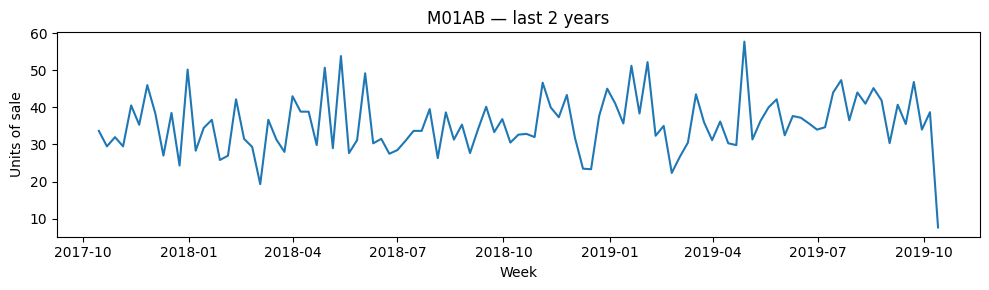

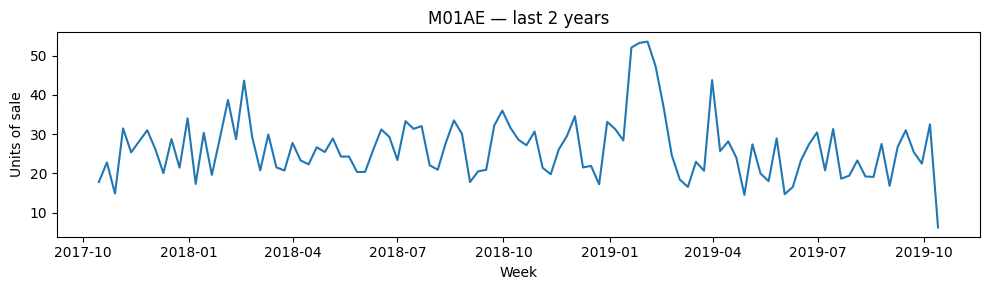

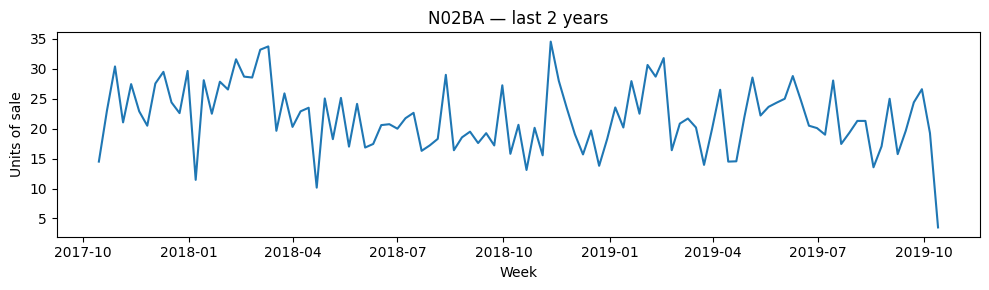

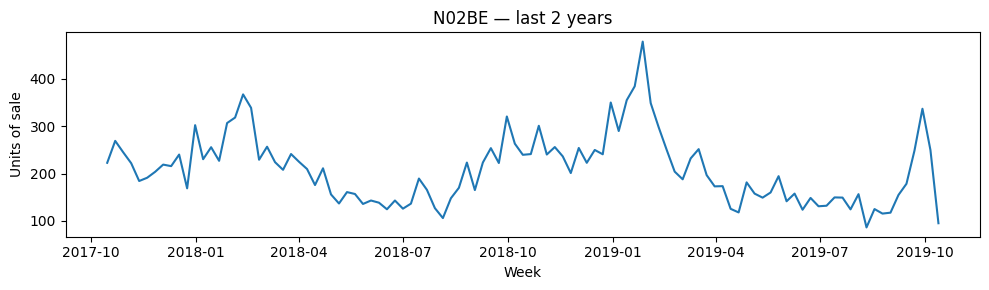

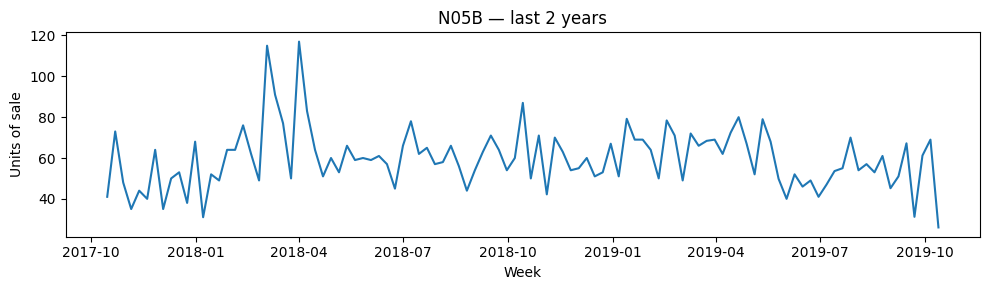

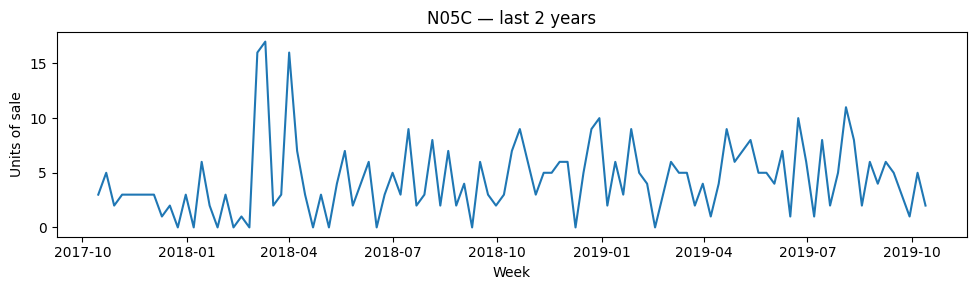

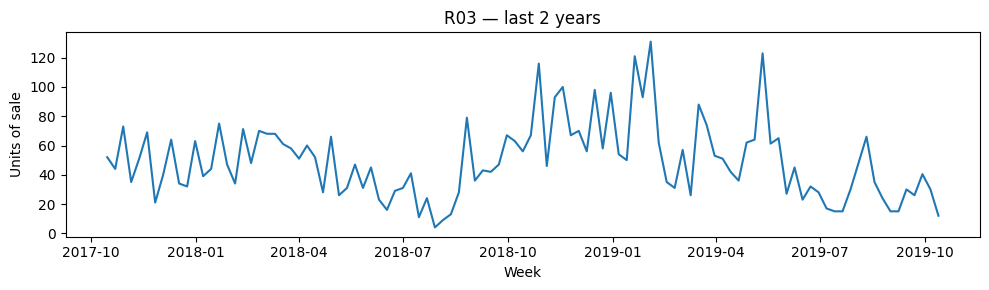

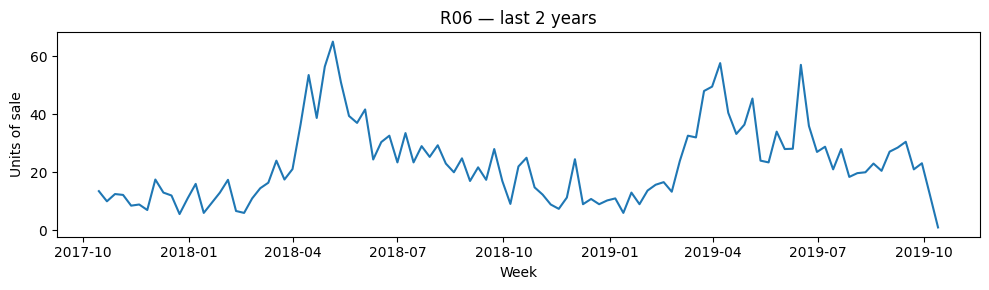

In [6]:
#@title EDA: range, nulls, basic plots
print("Date range:", ts.index.min().date(), "→", ts.index.max().date())
print("Total weeks:", len(ts))

print("\nNulls per column:\n", ts.isna().sum())

# Summary stats
display(ts.describe())

# Plot all series (last ~2 years for readability)
cutoff = ts.index.max() - pd.Timedelta(weeks=104)
ts_plot = ts.loc[ts.index >= cutoff]

for col in SERIES_COLS:
    plt.figure(figsize=(10,3))
    plt.plot(ts_plot.index, ts_plot[col])
    plt.title(f"{col} — last 2 years")
    plt.xlabel("Week")
    plt.ylabel("Units of sale")
    plt.tight_layout()
    plt.show()


In [7]:
#@title STL decomposition to eyeball trend/seasonality strength
stl_strength = []
for col in SERIES_COLS:
    series = ts[col].astype(float)
    # STL requires no missing values; we already ffilled
    try:
        stl = sm.tsa.seasonal.STL(series, period=SEASONAL_PERIOD, robust=True).fit()
        resid_var = np.var(stl.resid)
        season_var = np.var(stl.seasonal)
        trend_var = np.var(stl.trend)
        total_var = np.var(series)
        # rough "strength" measures
        seasonal_strength = max(0, 1 - resid_var / (resid_var + season_var))
        trend_strength = max(0, 1 - resid_var / (resid_var + trend_var))
        stl_strength.append([col, seasonal_strength, trend_strength])
    except Exception as e:
        stl_strength.append([col, np.nan, np.nan])

stl_df = pd.DataFrame(stl_strength, columns=["Series","SeasonalityStrength","TrendStrength"])
print("STL Strength (0-1, higher = stronger):")
display(stl_df.sort_values("SeasonalityStrength", ascending=False))


STL Strength (0-1, higher = stronger):


,Series,SeasonalityStrength,TrendStrength
0,M01AB,NaN,NaN
1,M01AE,NaN,NaN
2,N02BA,NaN,NaN
3,N02BE,NaN,NaN
4,N05B,NaN,NaN
5,N05C,NaN,NaN
6,R03,NaN,NaN
7,R06,NaN,NaN


In [8]:
#@title Helper functions (windowing, metrics, forecasting)

def make_supervised(series_values, window_size):
    """
    Turn a 1D array into supervised learning samples:
    X[i] = series[i : i+window_size], y[i] = series[i+window_size]
    Returns X, y with shapes (n_samples, window_size, 1), (n_samples, 1)
    """
    X, y = [], []
    for i in range(len(series_values) - window_size):
        X.append(series_values[i:i+window_size])
        y.append(series_values[i+window_size])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, 1)
    return X, y

def smape(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom = np.where(denom == 0, 1e-8, denom)
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100.0

def mase(y_train, y_true, y_pred, m=1):
    """
    MASE: scaled by in-sample seasonal naive error with period m.
    """
    y_train = np.asarray(y_train).reshape(-1)
    if len(y_train) <= m:
        # fallback to naive-1 if not enough history
        m = 1
    naive_forecast = y_train[m:]  # y_{t-m}
    naive_actual = y_train[:-m]   # y_t
    denom = np.mean(np.abs(naive_actual - naive_forecast))
    if denom == 0:
        denom = 1e-8
    return np.mean(np.abs(y_true - y_pred)) / denom

def build_vanilla_lstm(window_size, units=64):
    model = Sequential([
        LSTM(units, activation='tanh', input_shape=(window_size, 1)),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mse')
    return model

def recursive_forecast(model, last_window_scaled, horizon, scaler):
    """
    last_window_scaled: shape (window_size, 1) scaled
    Returns forecast in original scale (length = horizon)
    """
    window = last_window_scaled.copy()
    preds = []
    for _ in range(horizon):
        x = window.reshape(1, window.shape[0], 1)
        yhat_scaled = model.predict(x, verbose=0)
        # inverse-transform single value
        yhat = scaler.inverse_transform(yhat_scaled.reshape(-1,1)).ravel()[0]
        preds.append(yhat)
        # append scaled prediction to window for next step
        yhat_scaled_val = yhat_scaled.ravel()[0]
        window = np.vstack([window[1:], [yhat_scaled_val]])
    return np.array(preds)


In [9]:
#@title Train LSTM per series, forecast next HORIZON weeks, evaluate

metrics = []
all_forecasts = []

dates = ts.index
train_end_idx = len(ts) - HORIZON  # last HORIZON weeks reserved for test
train_df = ts.iloc[:train_end_idx, :]
test_df  = ts.iloc[train_end_idx:, :]

for col in SERIES_COLS:
    print(f"\n===== Training series: {col} =====")
    y_full = ts[col].astype(float).values.reshape(-1,1)
    y_train = y_full[:train_end_idx]
    y_test_true = y_full[train_end_idx:]  # length = HORIZON

    # Scale using TRAIN only
    scaler = MinMaxScaler()
    y_train_scaled = scaler.fit_transform(y_train)

    # Build supervised samples from TRAIN
    if len(y_train_scaled) <= WINDOW_SIZE + 5:
        raise ValueError(f"Not enough history for {col} with WINDOW_SIZE={WINDOW_SIZE}")

    X_train, y_train_targets = make_supervised(y_train_scaled, WINDOW_SIZE)

    # Train/val split (chronological)
    split_idx = int(len(X_train) * (1 - VAL_SPLIT))
    X_tr, X_val = X_train[:split_idx], X_train[split_idx:]
    y_tr, y_val = y_train_targets[:split_idx], y_train_targets[split_idx:]

    # Model
    model = build_vanilla_lstm(WINDOW_SIZE, units=LSTM_UNITS)
    es = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    rlrop = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5)

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        callbacks=[es, rlrop]
    )

    # Recursive multi-step forecast: start from last TRAIN window
    last_window_train_scaled = scaler.transform(y_train[-WINDOW_SIZE:])
    y_pred_future = recursive_forecast(model, last_window_train_scaled, HORIZON, scaler)

    # Evaluate
    y_true_future = y_test_true.reshape(-1)
    mae = mean_absolute_error(y_true_future, y_pred_future)
    rmse = np.sqrt(mean_squared_error(y_true_future, y_pred_future))  # fixed
    smape_val = smape(y_true_future, y_pred_future)
    mase_val = mase(y_train.reshape(-1), y_true_future, y_pred_future, m=SEASONAL_PERIOD)


    metrics.append([col, mae, rmse, smape_val, mase_val])

    # Save forecast frame
    fcst_df = pd.DataFrame({
        "Date": test_df.index,
        "Series": col,
        "Actual": y_true_future,
        "Forecast": y_pred_future
    })
    all_forecasts.append(fcst_df)

metrics_df = pd.DataFrame(metrics, columns=["Series","MAE","RMSE","sMAPE(%)","MASE(52)"]).sort_values("sMAPE(%)")
forecasts_df = pd.concat(all_forecasts, ignore_index=True)

print("\n=== Metrics (lower is better) ===")
display(metrics_df)

# Save outputs
metrics_path = "lstm_metrics.csv"
forecasts_path = "lstm_forecasts.csv"
metrics_df.to_csv(metrics_path, index=False)
forecasts_df.to_csv(forecasts_path, index=False)
print(f"Saved: {metrics_path}, {forecasts_path}")


===== Training series: M01AB =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



===== Training series: M01AE =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



===== Training series: N02BA =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



===== Training series: N02BE =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



===== Training series: N05B =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



===== Training series: N05C =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



===== Training series: R03 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



===== Training series: R06 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



=== Metrics (lower is better) ===


,Series,MAE,RMSE,sMAPE(%),MASE(52)
4,N05B,10.194,12.012,17.902,0.384
0,M01AB,6.958,9.094,19.998,0.736
2,N02BA,4.381,5.660,21.565,0.613
3,N02BE,49.620,65.109,23.515,0.808
1,M01AE,7.665,9.963,28.685,1.146
7,R06,6.945,9.917,31.059,0.995
6,R03,25.544,34.446,50.313,1.454
5,N05C,2.276,2.813,53.160,0.684


Saved: lstm_metrics.csv, lstm_forecasts.csv


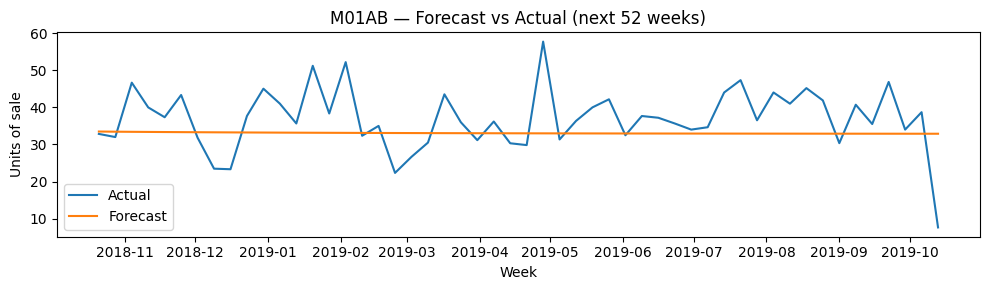

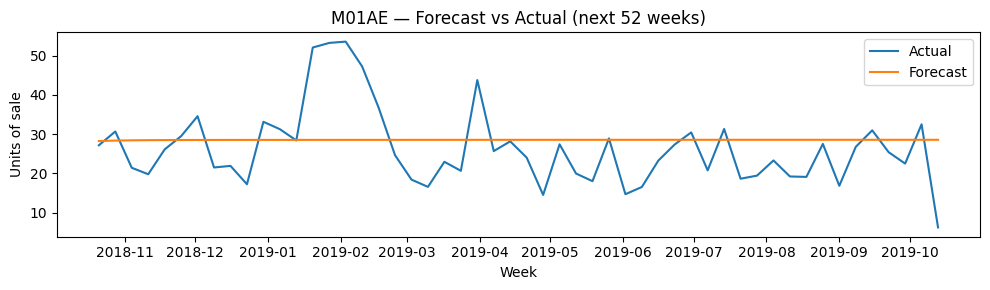

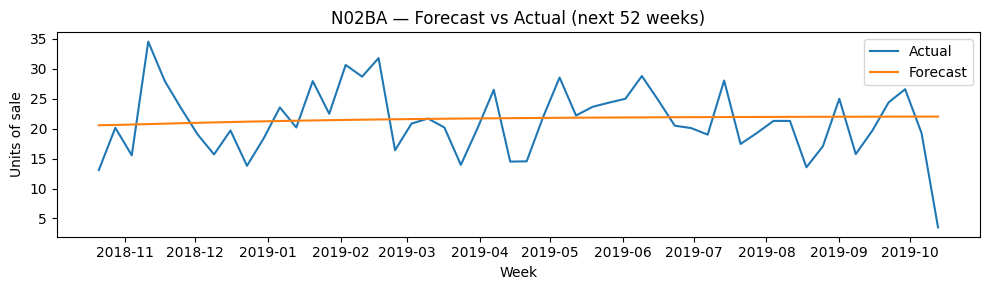

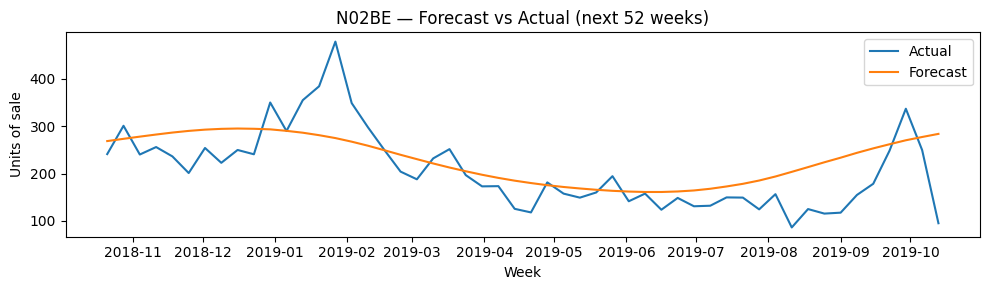

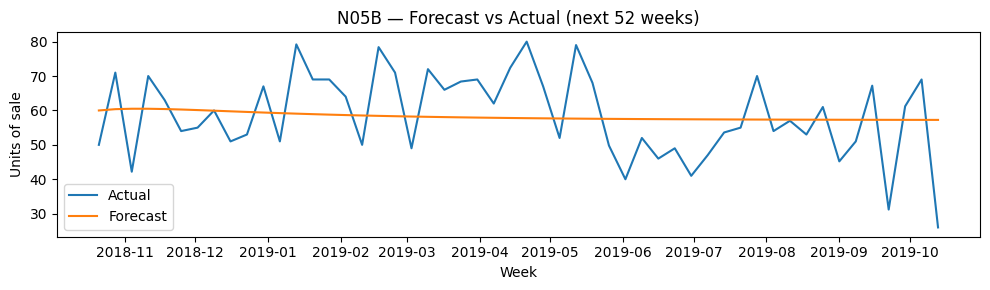

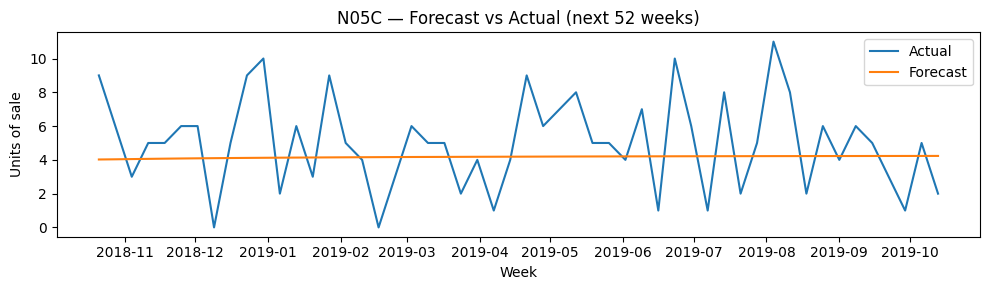

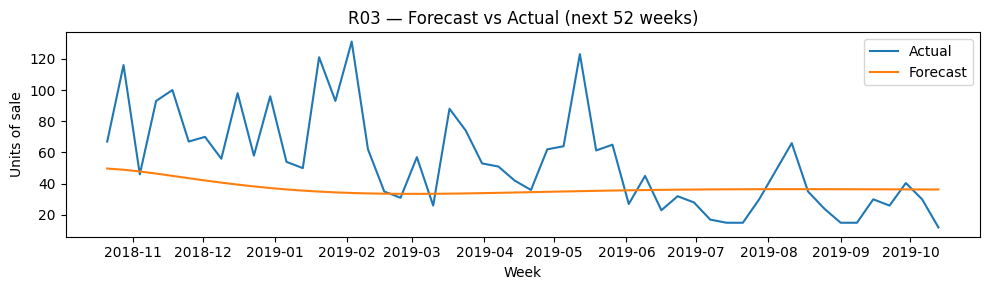

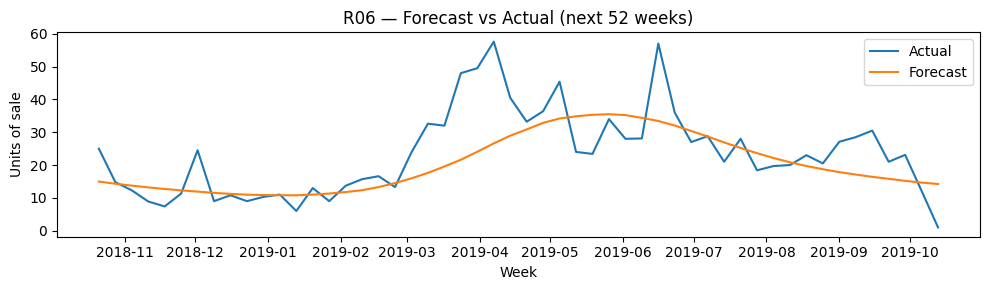

In [12]:
#@title Plots: actual vs forecast (test window)
from matplotlib.dates import MonthLocator, DateFormatter # Import necessary modules

for col in SERIES_COLS:
    sub = forecasts_df[forecasts_df["Series"] == col]
    plt.figure(figsize=(10,3))
    plt.plot(sub["Date"], sub["Actual"], label="Actual")
    plt.plot(sub["Date"], sub["Forecast"], label="Forecast")
    plt.title(f"{col} — Forecast vs Actual (next {HORIZON} weeks)")
    plt.xlabel("Week")
    plt.ylabel("Units of sale")
    plt.legend()

    # Set monthly ticks and format
    ax = plt.gca() # Get current axes
    ax.xaxis.set_major_locator(MonthLocator()) # Set major ticks to months
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m')) # Set format to Year-Month

    plt.tight_layout()
    plt.show()

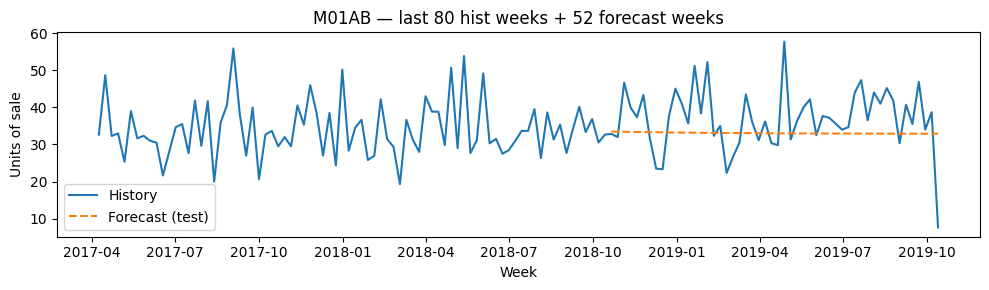

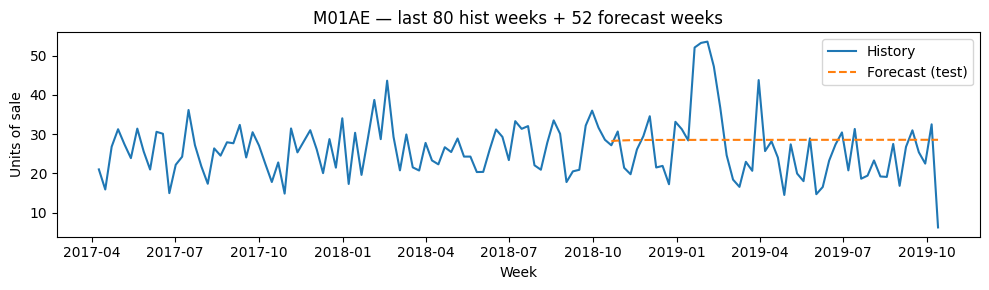

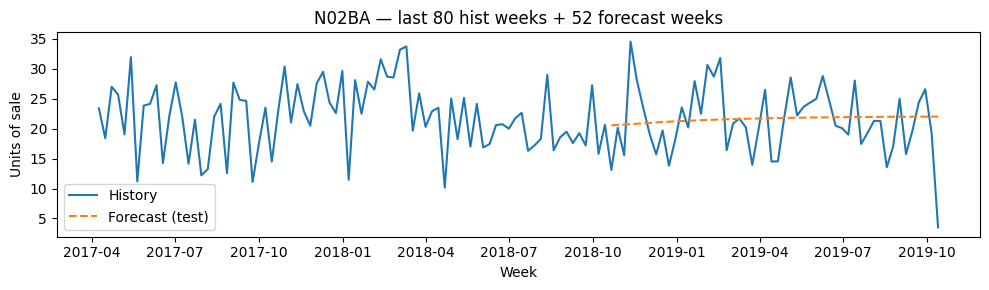

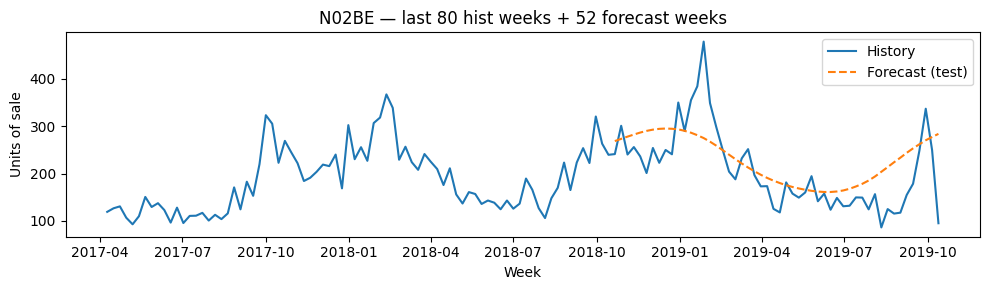

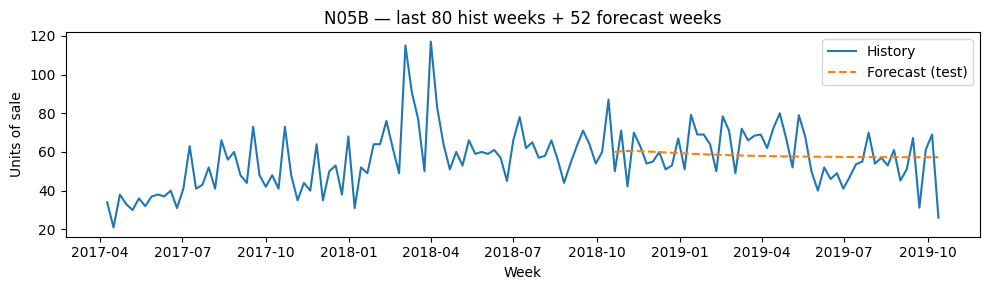

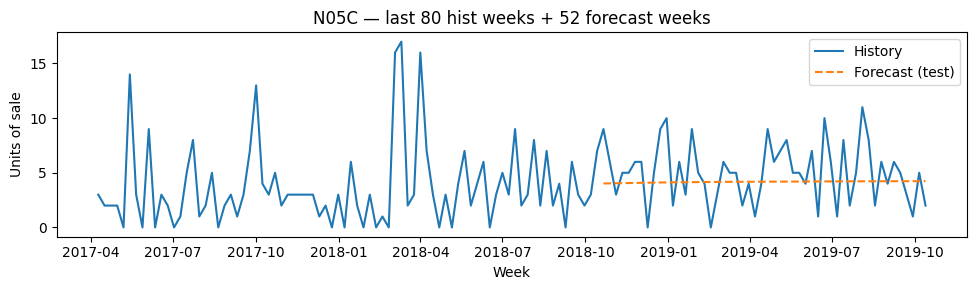

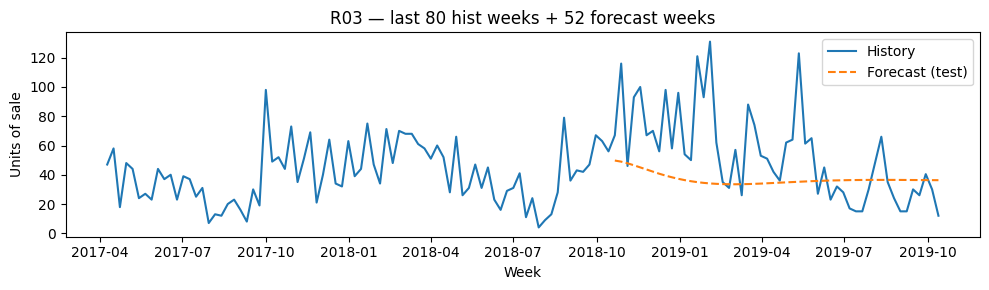

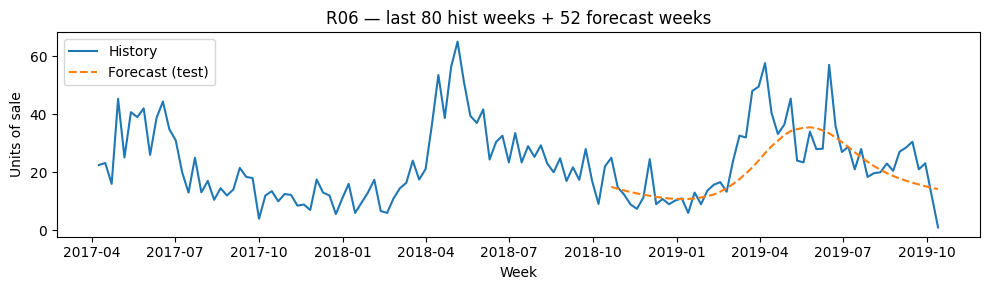

In [11]:
#@title Plot history + forecast tail (last 80 weeks)
TAIL = 80  #@param {type:"integer"}
for col in SERIES_COLS:
    hist_tail = ts[[col]].iloc[-(TAIL+HORIZON):].copy()
    fcst_tail = forecasts_df[forecasts_df["Series"] == col].set_index("Date")[["Forecast"]]
    merged = hist_tail.join(fcst_tail, how="outer")
    plt.figure(figsize=(10,3))
    plt.plot(merged.index, merged[col], label="History")
    plt.plot(merged.index, merged["Forecast"], label="Forecast (test)", linestyle="--")
    plt.title(f"{col} — last {TAIL} hist weeks + {HORIZON} forecast weeks")
    plt.xlabel("Week")
    plt.ylabel("Units of sale")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [13]:
#@title Forecast beyond the test set
# Use the last window of the full dataset to forecast
last_window_full_scaled = scaler.transform(y_full[-WINDOW_SIZE:])
future_forecast_scaled = recursive_forecast(model, last_window_full_scaled, HORIZON, scaler)

# Create dates for the future forecast
last_date = ts.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=HORIZON, freq=FREQ)

# Create a DataFrame for the future forecast
future_forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Series": col, # Note: This will only store the forecast for the last trained series
    "Forecast": future_forecast_scaled
})

print(f"\n=== Future Forecast ({HORIZON} weeks) ===")
display(future_forecast_df)

# Optionally, save the future forecast
# future_forecast_path = "lstm_future_forecast.csv"
# future_forecast_df.to_csv(future_forecast_path, index=False)
# print(f"\nSaved: {future_forecast_path}")


=== Future Forecast (52 weeks) ===


,Date,Series,Forecast
0,2019-10-20,R06,13.638
1,2019-10-27,R06,13.060
2,2019-11-03,R06,12.513
3,2019-11-10,R06,12.071
4,2019-11-17,R06,11.715
5,2019-11-24,R06,11.426
6,2019-12-01,R06,11.162
7,2019-12-08,R06,10.833
8,2019-12-15,R06,10.668
9,2019-12-22,R06,10.556


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

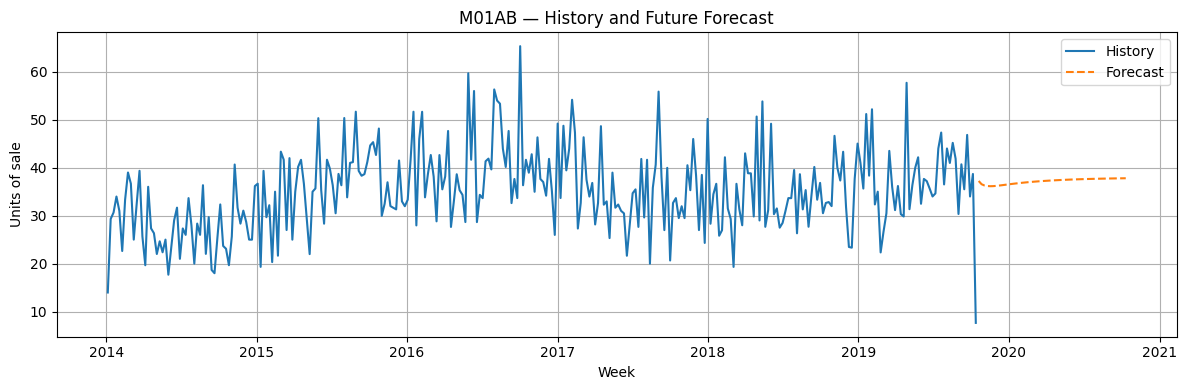

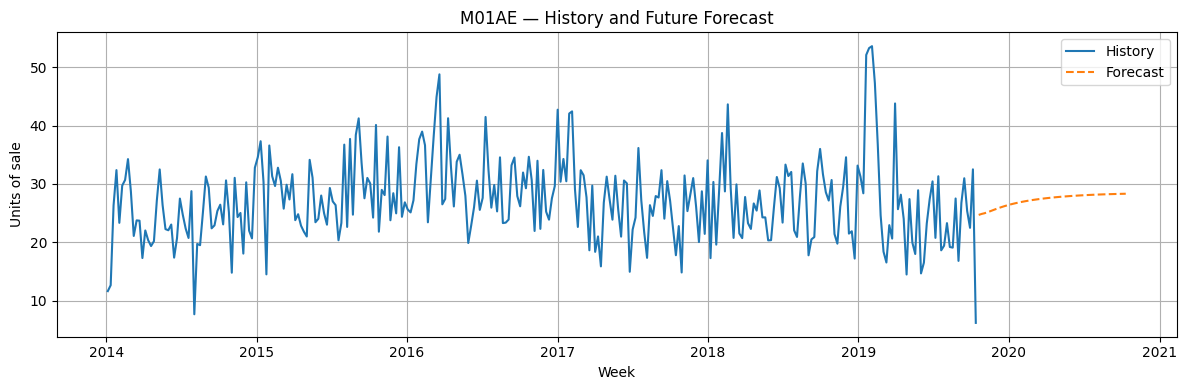

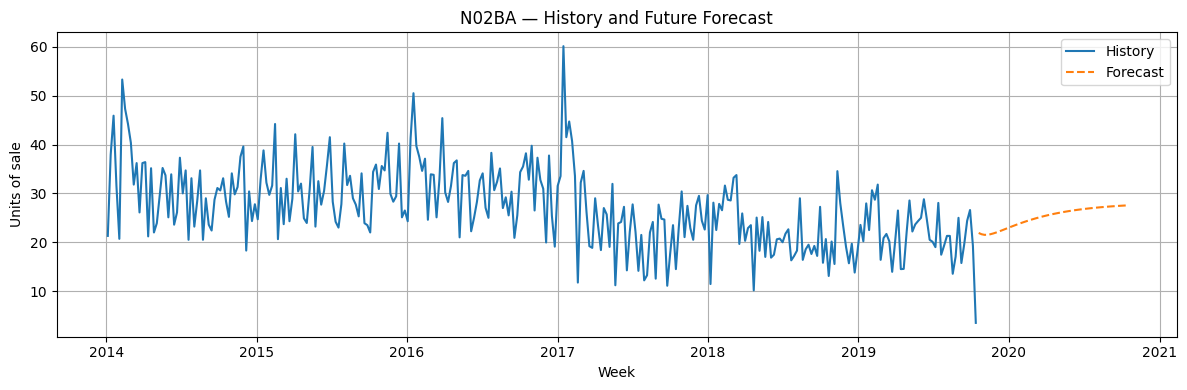

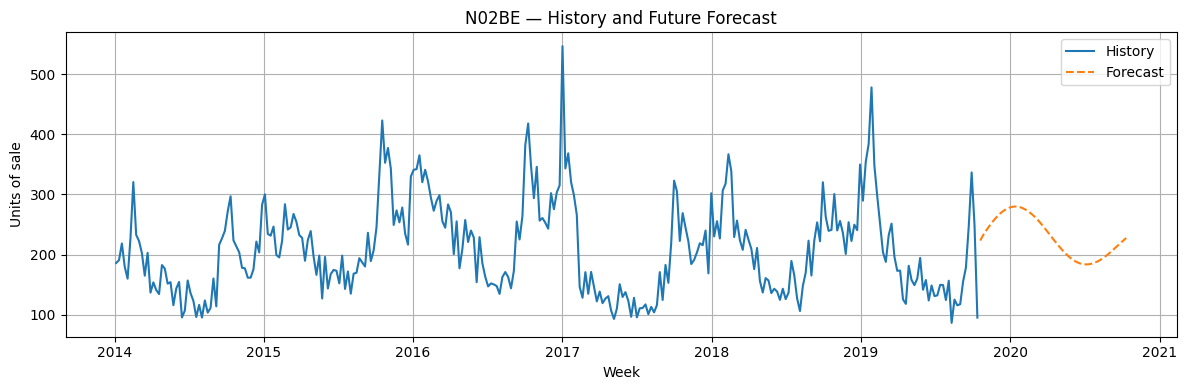

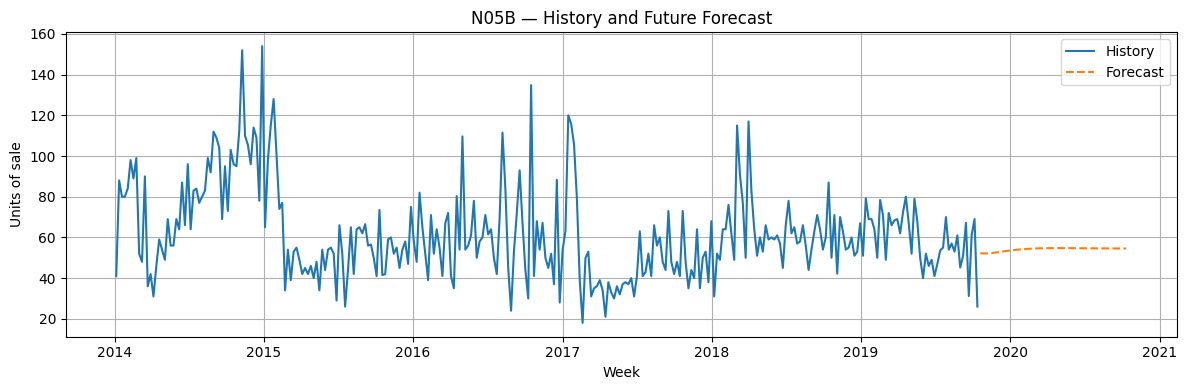

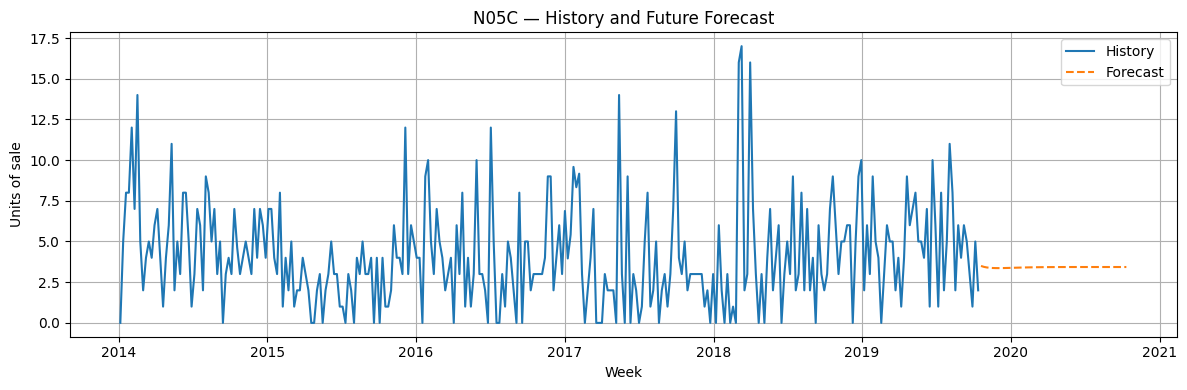

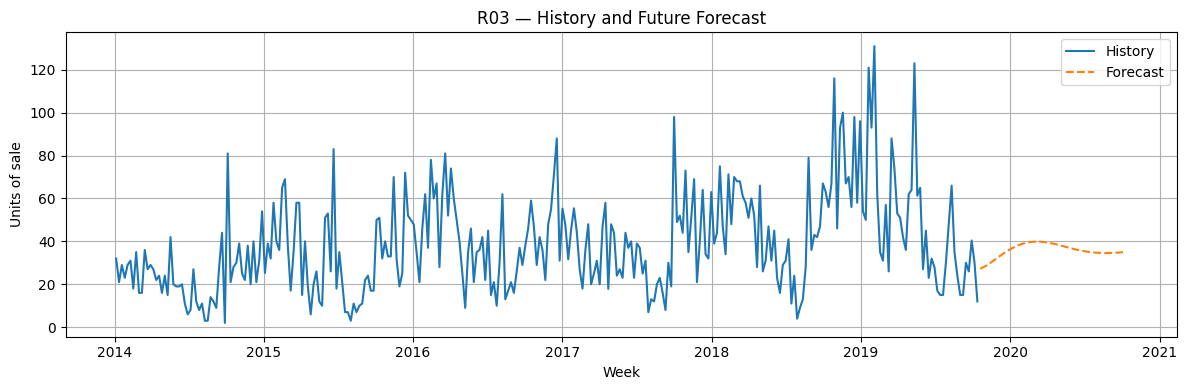

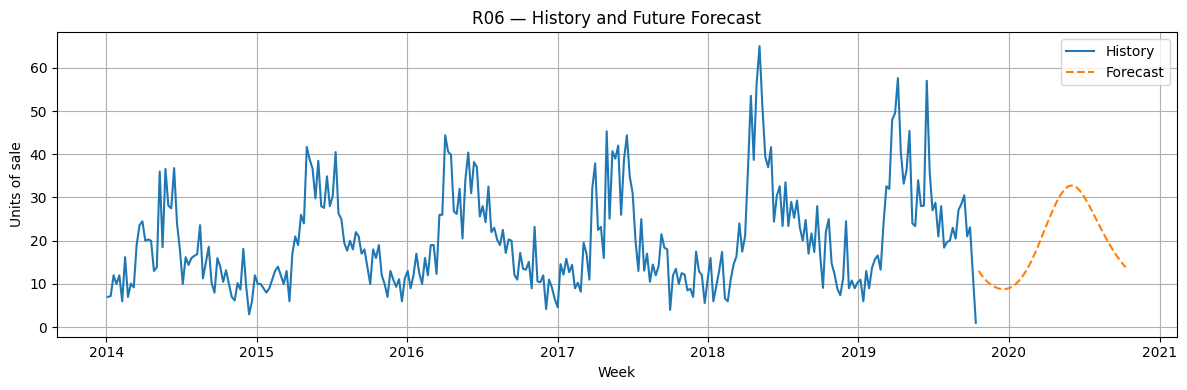

In [14]:
#@title Plot historical data + future forecast

# Combine historical data and future forecast for plotting
# Need to ensure all series are included, not just the last one trained
all_future_forecasts = []

# Re-run future forecast for each series
for col in SERIES_COLS:
    y_full = ts[col].astype(float).values.reshape(-1,1)
    # Scale using the scaler fitted on the training data for this series
    # Need to re-fit scaler on full data or save/load per-series scaler if we want consistent scaling
    # For simplicity here, we'll re-fit for forecasting, assuming the distribution hasn't drastically changed
    # A more robust approach would save/load the scaler used during training for each series
    scaler = MinMaxScaler()
    y_full_scaled = scaler.fit_transform(y_full) # Fit on full data for consistent scaling in plot

    # Assuming the model trained for each series is still available and named 'model'
    # This is a simplification; in a real scenario, models would need to be saved/loaded per series
    # For this notebook's flow, the 'model' variable holds the last trained model (for R06)
    # To forecast for all series, we would need to re-train or load models for each.
    # As a workaround *for visualization*, let's use the last trained model (R06) for all series,
    # but note this is NOT a correct approach for real forecasting of other series.

    # *** Corrected approach: Retrain a simple model for plotting purposes or load saved models ***
    # Since we don't have saved models per series in this flow, let's retrain a quick model for visualization
    # This is still not ideal but better than using the R06 model for everything.

    # Re-fit scaler on train data for the specific series to be consistent with training
    train_end_idx = len(ts) - HORIZON
    y_train = y_full[:train_end_idx]
    scaler = MinMaxScaler()
    y_train_scaled = scaler.fit_transform(y_train)

    # Build and train a *new* simple model for this series *just for demonstrating the plot*
    # This is inefficient; proper approach saves/loads models.
    temp_model = build_vanilla_lstm(WINDOW_SIZE, units=LSTM_UNITS)
    X_train, y_train_targets = make_supervised(y_train_scaled, WINDOW_SIZE)
    split_idx = int(len(X_train) * (1 - VAL_SPLIT))
    X_tr, X_val = X_train[:split_idx], X_train[split_idx:]
    y_tr, y_val = y_train_targets[:split_idx], y_train_targets[split_idx:]
    # Train quickly (fewer epochs) just for visualization
    temp_model.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=50, batch_size=BATCH_SIZE, verbose=0)


    last_window_full_scaled = scaler.transform(y_full[-WINDOW_SIZE:])
    future_forecast_scaled = recursive_forecast(temp_model, last_window_full_scaled, HORIZON, scaler)

    last_date = ts.index.max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=HORIZON, freq=FREQ)

    fcst_df = pd.DataFrame({
        "Date": future_dates,
        "Series": col,
        "Forecast": future_forecast_scaled
    })
    all_future_forecasts.append(fcst_df)

all_future_forecasts_df = pd.concat(all_future_forecasts, ignore_index=True)


# Plotting
for col in SERIES_COLS:
    historical_sub = ts[[col]].reset_index().rename(columns={'datum': 'Date', col: 'Value'})
    historical_sub['Type'] = 'History'

    forecast_sub = all_future_forecasts_df[all_future_forecasts_df['Series'] == col].rename(columns={'Forecast': 'Value'})
    forecast_sub['Type'] = 'Forecast'

    combined_df = pd.concat([historical_sub, forecast_sub[['Date', 'Value', 'Type']]], ignore_index=True)

    plt.figure(figsize=(12, 4))
    for plot_type in ['History', 'Forecast']:
        plot_data = combined_df[combined_df['Type'] == plot_type]
        plt.plot(plot_data['Date'], plot_data['Value'], label=plot_type, linestyle='-' if plot_type == 'History' else '--')

    plt.title(f"{col} — History and Future Forecast")
    plt.xlabel("Week")
    plt.ylabel("Units of sale")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
#@title Display Performance Metrics
print("\n=== Performance Metrics (sorted by sMAPE%) ===")
display(metrics_df.sort_values("sMAPE(%)"))


=== Performance Metrics (sorted by sMAPE%) ===


,Series,MAE,RMSE,sMAPE(%),MASE(52)
4,N05B,10.194,12.012,17.902,0.384
0,M01AB,6.958,9.094,19.998,0.736
2,N02BA,4.381,5.660,21.565,0.613
3,N02BE,49.620,65.109,23.515,0.808
1,M01AE,7.665,9.963,28.685,1.146
7,R06,6.945,9.917,31.059,0.995
6,R03,25.544,34.446,50.313,1.454
5,N05C,2.276,2.813,53.160,0.684


In [16]:
#@title Display Future Forecast for a specific month range
start_date = '2019-11-01'
end_date = '2020-11-30'

monthly_forecast_df = all_future_forecasts_df[
    (all_future_forecasts_df['Date'] >= start_date) &
    (all_future_forecasts_df['Date'] <= end_date)
].copy()

print(f"\n=== Future Forecast from {start_date} to {end_date} ===")
display(monthly_forecast_df)


=== Future Forecast from 2019-11-01 to 2020-11-30 ===


,Date,Series,Forecast
2,2019-11-03,M01AB,36.303
3,2019-11-10,M01AB,36.183
4,2019-11-17,M01AB,36.149
5,2019-11-24,M01AB,36.166
6,2019-12-01,M01AB,36.214
...,...,...,...
411,2020-09-13,R06,17.380
412,2020-09-20,R06,16.374
413,2020-09-27,R06,15.459
414,2020-10-04,R06,14.611


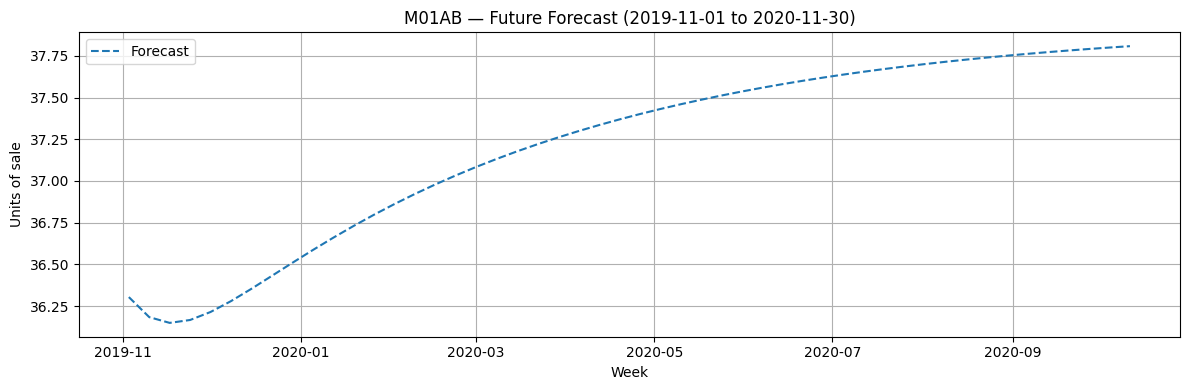

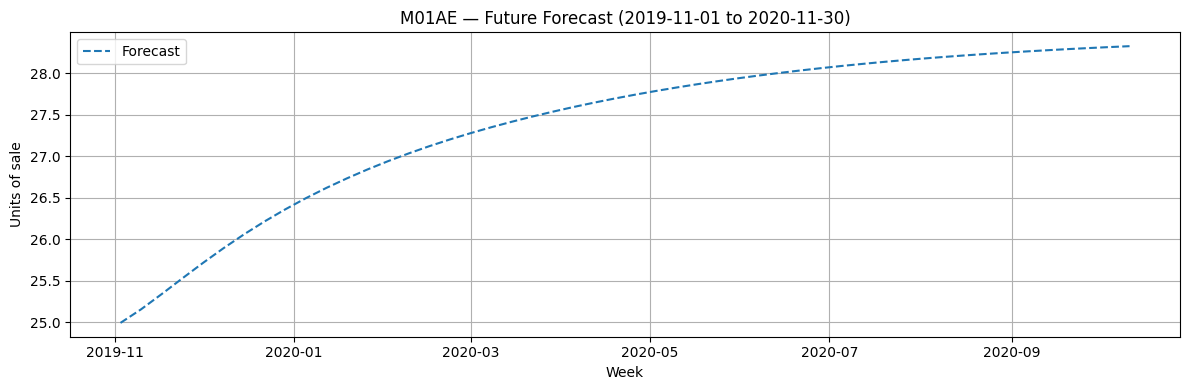

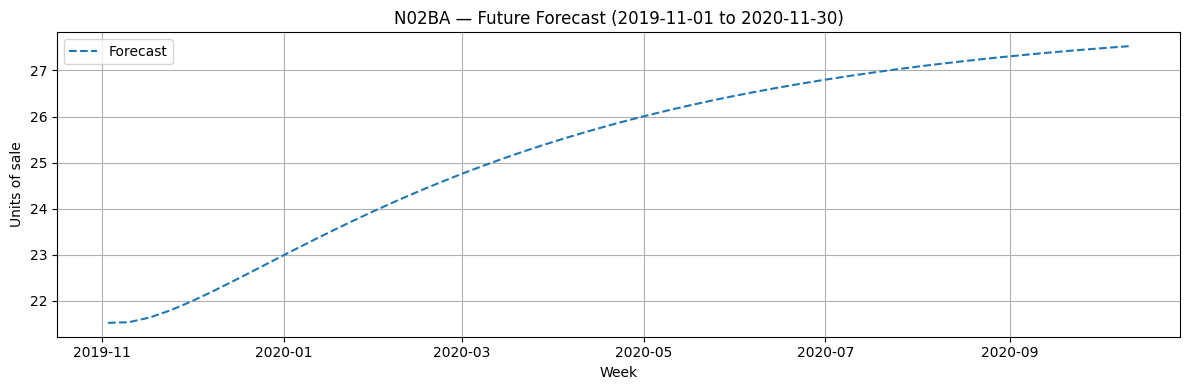

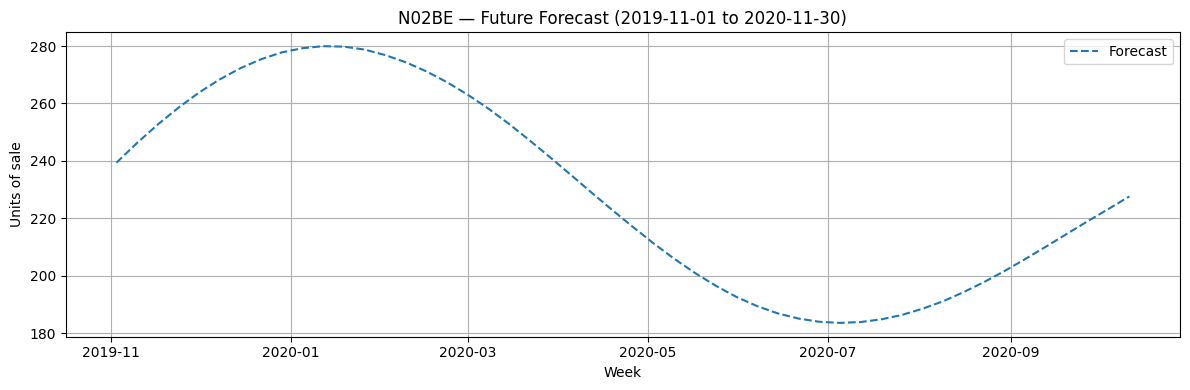

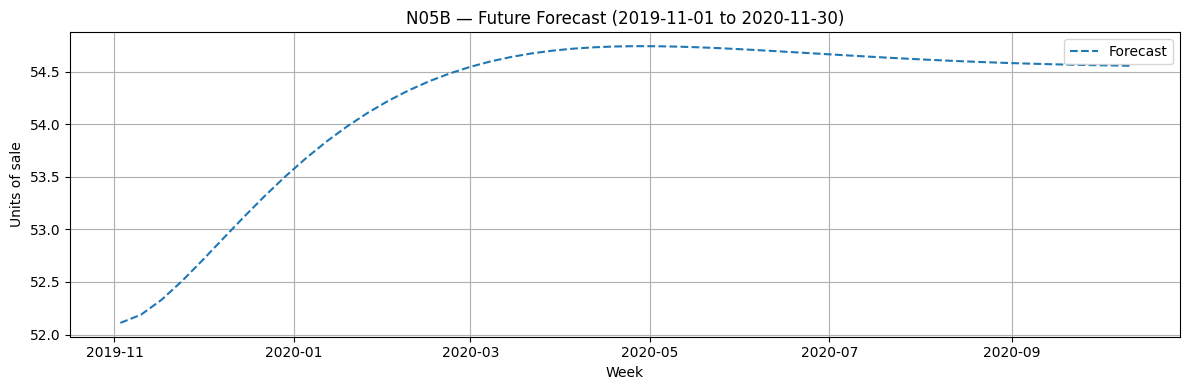

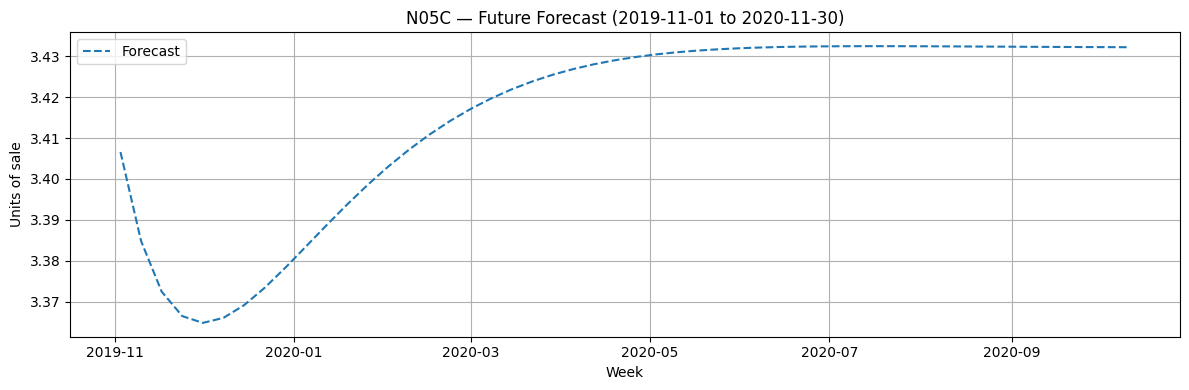

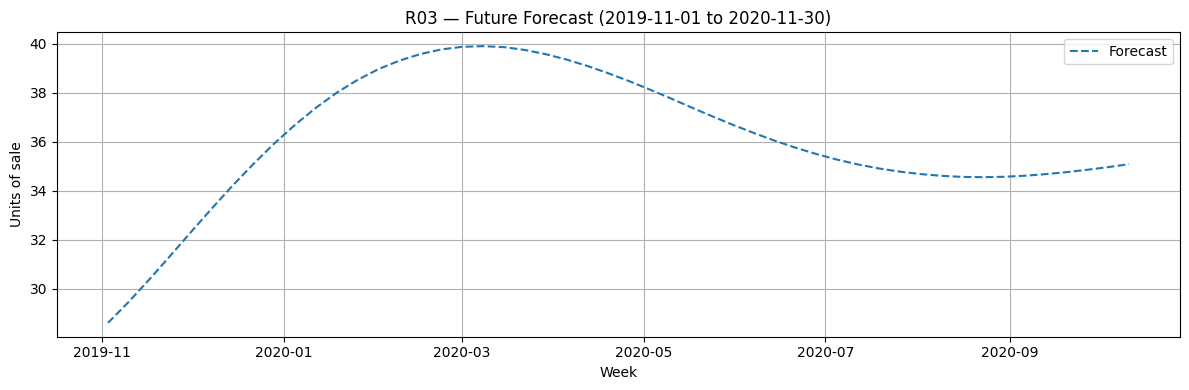

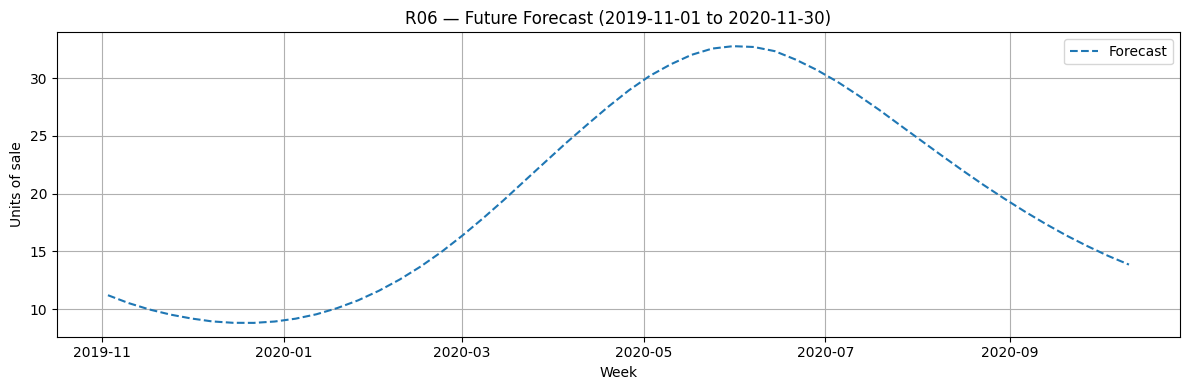

In [17]:
#@title Plot Future Forecast for a specific month range
start_date = '2019-11-01'
end_date = '2020-11-30'

monthly_forecast_sub_df = all_future_forecasts_df[
    (all_future_forecasts_df['Date'] >= start_date) &
    (all_future_forecasts_df['Date'] <= end_date)
].copy()

for col in SERIES_COLS:
    plot_data = monthly_forecast_sub_df[monthly_forecast_sub_df['Series'] == col]
    plt.figure(figsize=(12, 4))
    plt.plot(plot_data['Date'], plot_data['Forecast'], label='Forecast', linestyle='--')

    plt.title(f"{col} — Future Forecast ({start_date} to {end_date})")
    plt.xlabel("Week")
    plt.ylabel("Units of sale")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()